## Challenge 3

Derive metrics for tipping points

In [1]:
import xarray as xr # xarray for accessing and manipulating data
import numpy as np

In [2]:
path = "/gws/pw/j07/workshop/ARIA_src_data/"
t_path = path + "VERIFY_eORCA025_MED_UKESM_19900101_20710101_grid_T.nc"

In [3]:
ds = xr.open_dataset(t_path)

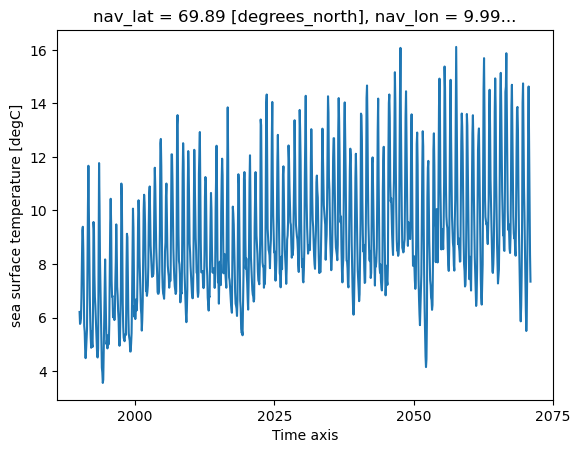

In [4]:
# One more recomendable way to pick a point is to first select a latitutde and longitude you want to investigate, for eg. latitude = 70N, longitude= 10E: 
target_lat = 70
target_lon = 10

# Then find the closest model point to these coordinates 
dist = ((ds.nav_lat - target_lat)**2 + (ds.nav_lon - target_lon)**2)**0.5

# Find the index of the closest point by: 
dist_1d = dist.stack(points=("y", "x")) # Turning the 2D grid (y, x) into a 1D list of points called "points". Each entry in "points" corresponds to the a set of (y, x).
ip = dist_1d.argmin("points") # getting index of the point with minimum distance (closest point) 

# Recover the original (y, x) indices from the stacked MultiIndex
j = dist_1d["y"].isel(points=ip).item()
i = dist_1d["x"].isel(points=ip).item()

tos_timeseries = ds.tos.isel(x=i,y=j)

tos_timeseries.plot()

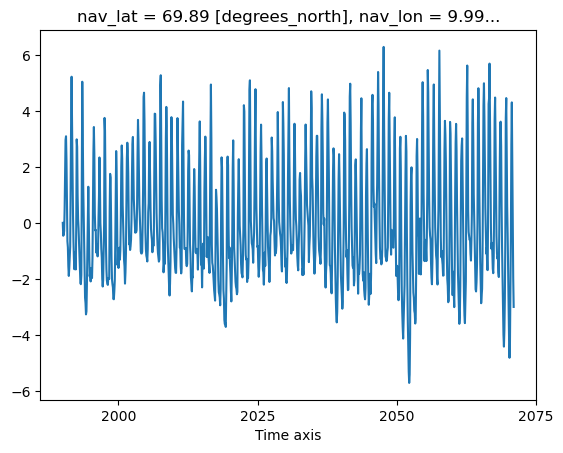

In [5]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit
detrended_tos = detrend_dim(tos_timeseries, "time_counter", 3)
detrended_tos.plot()

In [6]:
tos_variance = detrended_tos.rolling(time_counter=120).var()

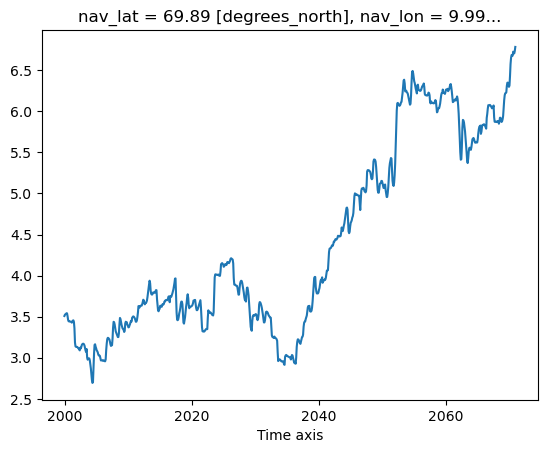

In [8]:
tos_variance.plot()

In [ ]:
# are we heading for a tipping point???

In [50]:
ww = 120 # window size 
roll = detrended_tos.rolling(time_counter=ww).construct("window") # build a rolling object with 'window' dimension

x1 = roll.isel(window=slice(0, -1)) # first window 'series' 
x2 = roll.isel(window=slice(1, None)) # shifted series to correlate

# Skip the first few positions. Are there 0, nans, or not enough values?? 
x1 = x1.isel(time_counter=slice(120, None))
x2 = x2.isel(time_counter=slice(120, None)) 


rac1 = xr.corr(x2, x1, dim="window") # autocorrelation for each running window


<xarray.DataArray (time_counter: 972, window: 120)> Size: 933kB
array([[        nan,         nan,         nan, ...,         nan,
                nan,  0.01341849],
       [        nan,         nan,         nan, ...,         nan,
         0.01341849, -0.44741911],
       [        nan,         nan,         nan, ...,  0.01341849,
        -0.44741911, -0.41308853],
       ...,
       [-0.67885154, -1.74616877, -2.32266358, ...,  4.31293969,
         2.08961498, -0.12001605],
       [-1.74616877, -2.32266358, -2.90617834, ...,  2.08961498,
        -0.12001605, -1.94730301],
       [-2.32266358, -2.90617834, -3.5904135 , ..., -0.12001605,
        -1.94730301, -2.98709555]], shape=(972, 120))
Coordinates:
    nav_lat        float32 4B 69.89
    nav_lon        float32 4B 9.999
    time_centered  (time_counter) object 8kB 1990-01-16 00:00:00 ... 2070-12-...
  * time_counter   (time_counter) object 8kB 1990-01-16 00:00:00 ... 2070-12-...
Dimensions without coordinates: window

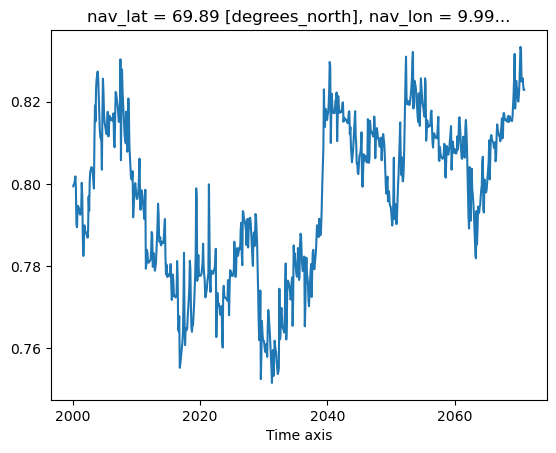

In [49]:
rac1.plot()
roll